In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load bp and get 2 first columns
with open("bp.csv", 'r') as bp_file:
    data = pd.read_csv(bp_file, sep=';')

print("BP file columns:\n\n%s" % data.columns)

# get first and second col and change representation to numpy-like
distance = data[data.columns[0]].as_matrix()
dose = data[data.columns[1]].as_matrix()

peak_max_position = distance[dose.argmax()]
print("\nDose == 1 is at range %s for %s" % (peak_max_position, data.columns[1]))

BP file columns:

Index(['x0', 'rs0', 'x0.955', 'y0.955', 'x1000', 'rs1000', 'x2000', 'y2000',
       'x3000', 'rs3000', 'x', 'rs4000', 'x.1', 'rs5000', 'x.2', 'rs6000',
       'x.3', 'rs7000', 'x.4', 'rs8000', 'x.5', 'rs9000', 'x.6', 'rs10000',
       'x.7', 'rs11000', 'x.8', 'rs12000', 'x.9', 'rs13000', 'x.10', 'rs14000',
       'x.11', 'rs15000', 'x.12', 'rs16000', 'x.13', 'rs17000', 'x.14',
       'rs18000'],
      dtype='object')

Dose == 1 is at range 28.24 for rs0


In [3]:
# load file with positions and weights
with open("pos.txt", "r") as pos_file:
    pos_we_data = pd.read_csv(pos_file, sep=';')

positions = pos_we_data['position'].as_matrix()
weights = pos_we_data['weight'].as_matrix()

print("Positions: %s" % positions)
print("Weights: %s " % weights)

Positions: [ 12.  14.  18.  20.  24.  26.]
Weights: [ 0.1    0.05   0.125  0.225  0.15   0.35 ] 


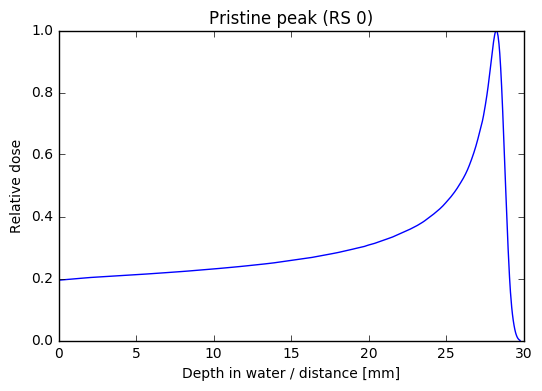

In [4]:
plt.plot(distance, dose)
plt.title("Pristine peak (RS 0)")
plt.xlabel("Depth in water / distance [mm]")
plt.ylabel("Relative dose")

Peak[0] -> position: 12.0 with weight: 0.1
Shifting peak by: 16.24

Temp positions for this peak:
[-16.24 -16.23 -16.22 ...,  13.51  13.52  13.53]

Temp dose for this peak:
[  1.94470000e-02   1.94520000e-02   1.94560000e-02 ...,   8.30000000e-05
   4.70000000e-05   1.10000000e-05]

Peak[1] -> position: 14.0 with weight: 0.05
Shifting peak by: 14.24

Temp positions for this peak:
[-14.24 -14.23 -14.22 ...,  15.51  15.52  15.53]

Temp dose for this peak:
[  9.72350000e-03   9.72600000e-03   9.72800000e-03 ...,   4.15000000e-05
   2.35000000e-05   5.50000000e-06]

Peak[2] -> position: 18.0 with weight: 0.125
Shifting peak by: 10.24

Temp positions for this peak:
[-10.24 -10.23 -10.22 ...,  19.51  19.52  19.53]

Temp dose for this peak:
[  2.43087500e-02   2.43150000e-02   2.43200000e-02 ...,   1.03750000e-04
   5.87500000e-05   1.37500000e-05]

Peak[3] -> position: 20.0 with weight: 0.225
Shifting peak by: 8.24

Temp positions for this peak:
[ -8.24  -8.23  -8.22 ...,  21.51  21.52  21.5

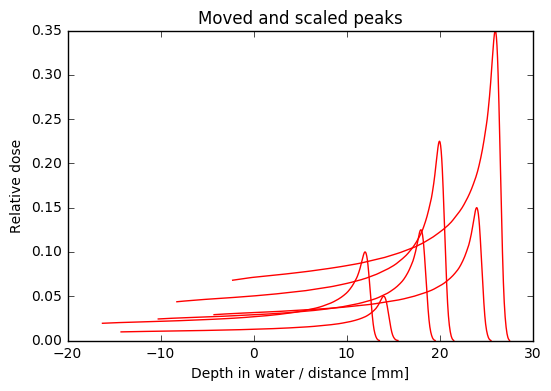

In [5]:
# try to find out how peaks with given positions and weight should look like (just modify data before passing it to pyplot)
single_peak_plots = []
for i in range(len(positions)):
    print("Peak[%s] -> position: %s with weight: %s" % (i, positions[i], weights[i]))

    # move peak to desired location if needed
    if abs(positions[i] - peak_max_position) > 0.01:
        print("Shifting peak by: %s\n" % abs(positions[i] - peak_max_position))
        temp_pos = distance + (positions[i] - peak_max_position)
        temp_dose = dose * weights[i]
        print("Temp positions for this peak:\n%s\n" % temp_pos)
        print("Temp dose for this peak:\n%s\n" % temp_dose)
        single_peak_plots.append(
            plt.plot(temp_pos, temp_dose, 'r', label="Pos " + str(positions[i]) + " wei: " + str(weights[i]))[0]
        )

plt.title("Moved and scaled peaks")
plt.xlabel("Depth in water / distance [mm]")
plt.ylabel("Relative dose")

In [6]:
def make_function_from_points(x, y, deg):
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
    z = np.polyfit(x, y, deg)
    f = np.poly1d(z)
    return f

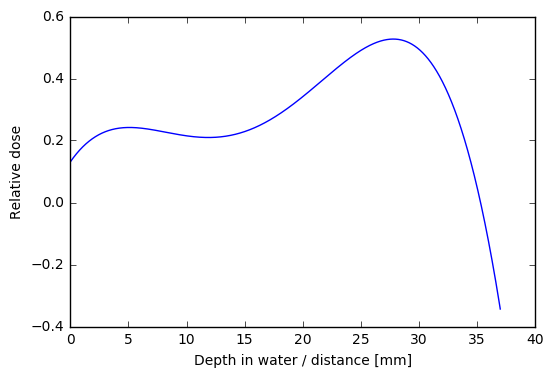

In [7]:
# try to polyfit pristine peak
peak_f = make_function_from_points(distance, dose, 4)

# just some testing domain
domain = np.arange(0, 37, 0.01)

plt.plot(domain, peak_f(domain))
plt.xlabel("Depth in water / distance [mm]")
plt.ylabel("Relative dose")

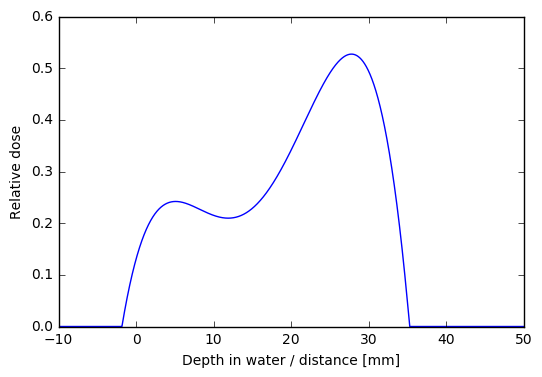

In [8]:
def peak_function(x):
    """
    Return polyfit_func(x) when it's positive else return 0
    """
    temp_arr = None
    peak_f = make_function_from_points(distance, dose, 4)
    for e in x:
        if peak_f(e) >= 0:
            temp_arr = np.append(temp_arr, peak_f(e))
        else:
            temp_arr = np.append(temp_arr, 0.0)
    return temp_arr[1:]

huge_domain = np.arange(-10, 50, 0.01)

plt.plot(huge_domain, peak_function(huge_domain))
plt.xlabel("Depth in water / distance [mm]")
plt.ylabel("Relative dose")

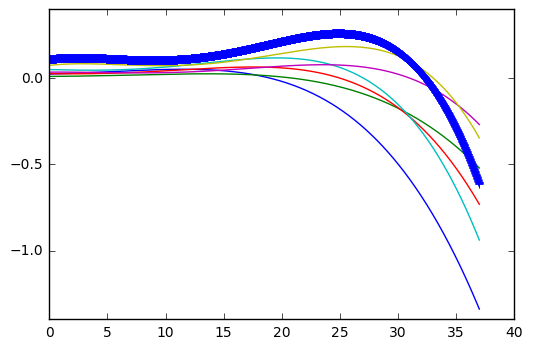

In [9]:
peak_f_list = []
# construct polymonial for each peak using its position and weight
for j in range(len(positions)):
    peak_f_list.append(
        make_function_from_points(
            x=distance + (positions[j] - peak_max_position),
            y=dose * weights[j],
            deg=4)
    )

for f in peak_f_list:
    plt.plot(domain, f(domain))

# sum peak polynomials to one
for p in range(len(peak_f_list)-1):
    sobp_poly = np.polyadd(peak_f_list[p], peak_f_list[p+1])

plt.plot(domain, sobp_poly(domain), 'b+')

In [10]:
def peak_function_with_bounds(x_to_fit, y_to_fit, deg, x):
    """
    Returns a np,ndarray of values for given domain (x).
    
    x_to_fit, y_to_fit - data used to polyfit a function.
    deg - degree passed to polyfit function
    x - domain to calculate values, which we return as np.ndarray
    
    polyfit_func(x) when it's positive else 0.0
    """
    temp_arr = None
    # polyfit a function from given data
    temp_peak_func = make_function_from_points(x_to_fit, y_to_fit, deg)
    for e in x:
        if temp_peak_func(e) >= 0:
            temp_arr = np.append(temp_arr, temp_peak_func(e))
        else:
            temp_arr = np.append(temp_arr, 0.0)
    return temp_arr[1:]

[0.0 0.0 0.0 ..., 0.0 0.0 0.0]


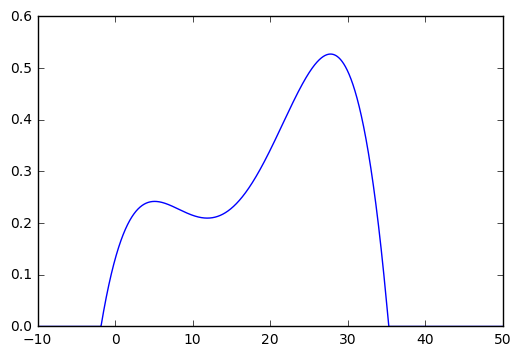

In [11]:
pp = peak_function_with_bounds(distance, dose, 4, huge_domain)

print(pp)
plt.plot(huge_domain, pp)

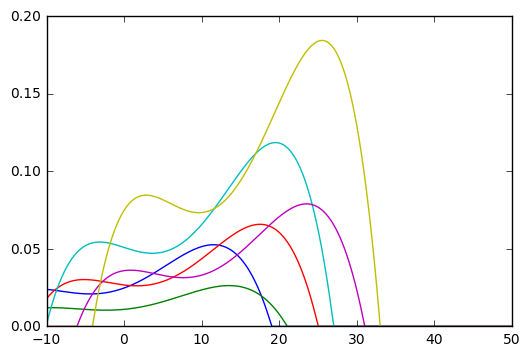

In [12]:
# construct polymonial for each peak using its position and weights 
# this time use peak_function_with_bounds to get rid of negative values
y_peak_values = []
for j in range(len(positions)):
    temp_y_peak = peak_function_with_bounds(
        distance + (positions[j] - peak_max_position),
        dose * weights[j],
        4,
        huge_domain)
    y_peak_values.append(temp_y_peak)
    plt.plot(huge_domain, temp_y_peak)

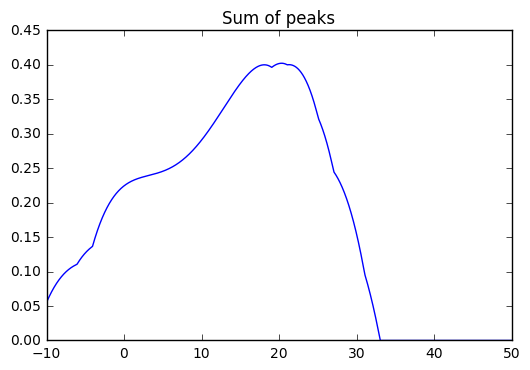

In [13]:
plt.plot(huge_domain, sum(y_peak_values))
plt.title("Sum of peaks")

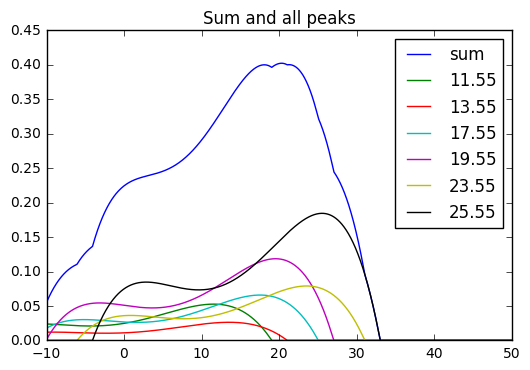

In [14]:
plots = [plt.plot(huge_domain, sum(y_peak_values), "-", label="sum")[0]]
for p in y_peak_values:
    plots.append(plt.plot(huge_domain, p, label="%.2f" % huge_domain[np.argmax(p)])[0])
plt.title("Sum and all peaks")
plt.legend(handles=plots)